In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils import data
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn import datasets
from itertools import chain as ichain
import time

In [11]:
BATCH_SIZE = 32
def generator_input_sampler(latent_space, batch_size = BATCH_SIZE, nc = 10):
    """ 
    Generates latent space values clipped to (-1,1), zc and indexes of zc depending on the number of classes >nc<
    \n
    Input: \n
    latentspace size, batchsize, nc default = 10
    \n
    Output:\n
    latentspace vector, zc, zc_idx
    """
    
    batch = torch.randn((batch_size, latent_space))
    clipped_batch = torch.FloatTensor(np.clip(batch.numpy(), -1, 1))
    zc_idx = torch.empty(batch_size, dtype=torch.long)
    zc_idx = zc_idx.random_(nc)
    zc = torch.Tensor(batch_size, nc).fill_(0)
    zc = zc.scatter_(1, zc_idx.unsqueeze(1), 1.)
    return clipped_batch, zc, zc_idx
from torch.autograd import grad as torch_grad
def preprocess_img(img):
    """
    Preprocess the images that the are normalized and clipped to a range between -1 and 1
    Input: Batch of images
    Output: Batch of normalized and clipped images
    """
    img = (img.float() / 255- 0.5) * 2
    img = torch.FloatTensor(np.clip(img.numpy(), -1, 1))      
    return img

def deprocess(x):
    """
    Deprocess the normalized vector images back to image format in range 0,255 
    Input: norm image vector with size (1,784)
    Output: image Tensor size (28,28)
    """
    x = (x.detach() / 2 + 1) * 255
    x = torch.clamp(x, min = 0, max = 255)
    return x.view(28,28)

def make_labels(size):
    # returns real and fake lables
    return torch.ones(size,1), torch.zeros(size,1)

class View(nn.Module):
    def __init__(self, shape):
        super(View, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(x.size(0),*self.shape)

def calc_gradient_penalty(netD, real_data, generated_data):
    # GP strength
    LAMBDA = 10

    b_size = real_data.size()[0]

    # Calculate interpolation
    alpha = torch.rand(b_size,1, 1, 1)
    real_data = real_data.unsqueeze(1)
    alpha = alpha.expand_as(real_data)
    
    interpolated = alpha * real_data.data + (1 - alpha) * generated_data.cpu().data
    interpolated = Variable(interpolated, requires_grad=True)

    # Calculate probability of interpolated examples
    prob_interpolated = netD(interpolated.squeeze(1).to(device)).cpu()

    # Calculate gradients of probabilities with respect to examples
    gradients = torch_grad(outputs=prob_interpolated, inputs=interpolated,
                           grad_outputs=torch.ones(prob_interpolated.size()),
                           create_graph=True, retain_graph=True)[0]

    # Gradients have shape (batch_size, num_channels, img_width, img_height),
    # so flatten to easily take norm per example in batch
    gradients = gradients.view(b_size, -1)

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

    # Return gradient penalty
    return LAMBDA * ((gradients_norm - 1) ** 2).mean()

In [4]:

from torchvision.datasets import MNIST
#https://github.com/Manuel4131/GoMNIST/tree/master/data

data_train = MNIST('~/pytorch_data', train=True, download=True,transform = transforms.Compose(
    [transforms.ToTensor()]))

In [6]:
X_train = data_train.train_data
#print(X_train[0])
#print(X_train[0].shape)
X_train = preprocess_img(X_train)
y_train = data_train.train_labels
print(len(X_train))
print(len(y_train))
import torch.utils.data as data_utils
dataset = data_utils.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(dataset,
                                          batch_size=32,
                                          shuffle=True)

60000
60000


In [7]:
class Generator(nn.Module):
    def __init__(self, latent_dim, nr_classes,img_shape = (1,28,28)):
        super(Generator, self).__init__()
        self.img_shape = img_shape
        self.ishape = (128,7,7)
        self.dim = int(np.prod(self.ishape))
        self.network = nn.Sequential(nn.Linear(latent_dim + nr_classes, 1024),
                                    nn.ReLU(),
                                    nn.BatchNorm1d(1024),
                                    nn.Linear(1024, self.dim),
                                    nn.ReLU(),
                                    nn.BatchNorm1d(self.dim),
                                    View(self.ishape), #Reshape
                                    nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = 4, stride=2, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(64),
                                    nn.ConvTranspose2d(in_channels = 64, out_channels = 1, kernel_size = 4, stride=2, padding=1),
                                    nn.Sigmoid())
                                    
    def forward(self, zn, zc):
        x = torch.cat((zn,zc), dim = 1)
        x = self.network(x)
        # reshape
        x = x.view(x.size(0), *self.img_shape)
        return x

    
class Encoder(nn.Module):
    def __init__(self, latent_dim, nr_classes):
        super(Encoder, self).__init__()
        # bekommt 28x28 input image
        self.latent_dim = latent_dim
        self.logits_out = int(np.prod((128,5,5)))
        self.logits_conv_shape = (self.logits_out,)
        self.encoder = nn.Sequential(nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = 4, stride = 2 ),
                                    nn.LeakyReLU(0.2),
                                    nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size= 4, stride = 2),
                                    nn.LeakyReLU(0.2),
                                    View(self.logits_conv_shape),
                                    nn.Linear(self.logits_out,1024),
                                    nn.LeakyReLU(0.2),
                                    nn.Linear(1024,self.latent_dim + nr_classes)
                                    )
        
    def forward(self, x):
        z_img = self.encoder(x)
        z = z_img.view(z_img.shape[0],-1)
        # Seperating continous and one-hot vectors
        zn = z[:, :self.latent_dim]
        zc_logits = z[:, self.latent_dim:]
        # Softmax on last 10 (nr classes) to obtain zc
        zc = torch.softmax(zc_logits, dim = 1)
        return zn, zc, zc_logits
        
        
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.logits_out = int(np.prod((128,5,5)))
        self.logits_conv_shape = (self.logits_out,)
        self.network = nn.Sequential(nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = 4, stride = 2 ),
                                    nn.LeakyReLU(0.2),
                                    nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 4, stride = 2),
                                    nn.LeakyReLU(0.2),
                                    View(self.logits_conv_shape),                                    
                                    nn.Linear(self.logits_out,1024),
                                    nn.LeakyReLU(0.2),
                                    nn.Linear(1024,1)
                                    )
    def forward(self, x):
        x = x.unsqueeze(1)
        return self.network(x)

In [8]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")
print(device)
latent_space_zn = 30 # latentspace
nr_c = 10 # nr of classes
#img_digits_shape = 784 
generator = Generator(latent_space_zn, nr_c).to(device)
encoder = Encoder(latent_space_zn, nr_c).to(device)
discriminator = Discriminator().to(device)

beta1 = 0.5
beta2 = 0.9
lr = 1e-4

generator_param_chain = ichain(generator.parameters(),
                      encoder.parameters())
optimizer_G = optim.Adam(generator_param_chain,lr = lr, betas = (beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters(), lr = lr, betas = (beta1, beta2))

cross_entropy_loss = torch.nn.CrossEntropyLoss()
mse_loss = torch.nn.MSELoss()

print(generator)
print("\n", encoder)
print("\n", discriminator)

cuda
Generator(
  (network): Sequential(
    (0): Linear(in_features=40, out_features=1024, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=1024, out_features=6272, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(6272, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): View()
    (7): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (11): Sigmoid()
  )
)

 Encoder(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (3): LeakyReLU(negative_slope=0.2)
    (4): View()
    (5): Linear(in_features=3200, out_features=1024, bi

/home/sebastian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: DeprecationWarning: This function is deprecated. Please call randint(0, 31 + 1) instead


Episode: 0 -- Discriminator loss: -40.127029907226564 -- Generator loss: -0.7733997808774312
Episode: 1 -- Discriminator loss: -40.165033034261064 -- Generator loss: 0.6881092998504639
Episode: 2 -- Discriminator loss: -40.1751032816569 -- Generator loss: 8.004814259529114
Episode: 3 -- Discriminator loss: -40.18058465169271 -- Generator loss: 36.19274320500692
Episode: 4 -- Discriminator loss: -40.18292133178711 -- Generator loss: 88.25471420491536
Episode: 5 -- Discriminator loss: -40.18454538370768 -- Generator loss: 151.87871618245444
Episode: 6 -- Discriminator loss: -40.18759633178711 -- Generator loss: 356.93394541422526
Episode: 7 -- Discriminator loss: -40.18987290852865 -- Generator loss: 556.7193373250326
Episode: 8 -- Discriminator loss: -40.1887630452474 -- Generator loss: 1358.5245010742187
Episode: 9 -- Discriminator loss: -40.18738350830078 -- Generator loss: 2124.225242683919
Training for 9.208959174156188 min


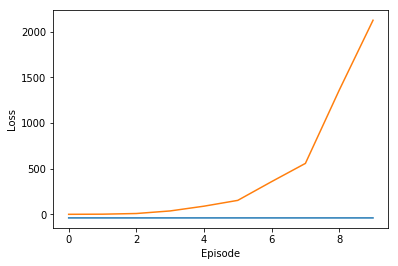

In [19]:
start_time = time.time()
#writer = SummaryWriter()
step = 0
epochs = 10
overall_loss_d = []
overall_loss_g = []
overall_loss_e = []
saved_generator_imgs = [] #saves one image each episode
generator_predictions = [] # saves the predictions of the discriminator to the fake images
for epoch in range(epochs):
    episodic_loss_d = []
    episodic_loss_g = []
    episodic_loss_e = []
    for idx, batch in enumerate(data_loader):
        
        # Training the Discriminator:
        discriminator.train()
        generator.eval()
        encoder.eval()
        x, y = batch
        zn, zc, zc_idx = generator_input_sampler(latent_space_zn, batch_size=32) # create fake digits
        #print(zn.shape, zc.shape, zc_idx.shape)
        x_fake = generator(zn.to(device),zc.to(device)) # create fake imgs
        
        grad_penalty = calc_gradient_penalty(discriminator, x, x_fake)
        pred_real = discriminator(x.to(device))
        pred_fake = discriminator(x_fake.squeeze(1).to(device))
        loss_d = (torch.mean(pred_real.cpu()) - torch.mean(pred_fake.cpu()) + grad_penalty.cpu()).cpu()
        discriminator.zero_grad()
        #writer.add_scalar("Discriminator loss",lossd.mean(), step)
        loss_d.backward()
        optimizer_D.step()
        episodic_loss_d.append(loss_d.cpu().item())
        
        # Training the Generator:
        discriminator.eval()
        generator.train()
        encoder.train()
        zn, zc, zc_idx = generator_input_sampler(latent_space_zn, batch_size=32) # create fake digits
        x_fake = generator(zn.to(device),zc.to(device)) # create fake imgs
        pred = discriminator(x_fake.squeeze(1).to(device))
        
        enc_gen_zn, enc_gen_zc, enc_gen_zc_logits = encoder(x_fake)
        
        if idx == 0:
            # Saves the first produced image each episode
            random_nr = np.random.random_integers(0,BATCH_SIZE-1)
            saved_generator_imgs.append(deprocess(x_fake[random_nr]))
            generator_predictions.append(pred[random_nr])
        
        generator.zero_grad()
        # calc losses:
        zn_loss = mse_loss(enc_gen_zn, zn.to(device))
        zc_loss = cross_entropy_loss(enc_gen_zc_logits, zc_idx.to(device))
        e_loss = zn_loss + zc_loss
        # generator loss
        g_loss = torch.mean(pred) + 10 * zn_loss + 10 * zc_loss   # value 10 depents on nr of classes
        
        #writer.add_scalar("Generator loss",lossg.mean(), step)
        g_loss.backward()
        optimizer_G.step()
        episodic_loss_g.append(g_loss.cpu().item()) 
        episodic_loss_e.append(e_loss.cpu().item())
        step += 1
        # Debugging
        #if idx == 1:
        #    break
    overall_loss_g.append(np.array(episodic_loss_g).mean())
    overall_loss_d.append(np.array(episodic_loss_d).mean())
    print("Episode: {} -- Discriminator loss: {} -- Generator loss: {}".format(epoch, np.array(episodic_loss_d).mean(), np.array(episodic_loss_g).mean()))

end_time = time.time()

print("Training for {} min".format((end_time-start_time)/60))
plt.plot(overall_loss_d)
plt.plot(overall_loss_g)
plt.ylabel("Loss")
plt.xlabel("Episode")
plt.show()

In [20]:

from sklearn.manifold import TSNE
import matplotlib
import matplotlib.cm as cm
tsne = TSNE(n_components=2, verbose=1, init='pca', random_state=42)

In [31]:
imgs_ = []
labels_ = []
for i in range(100):
    imgs, labels = next(iter(data_loader))
    imgs_.append(imgs)
    labels_.append(labels)
imgs = torch.cat(imgs_, dim = 0)
labels = torch.cat(labels_, dim = 0)

enc_zn, enc_zc, enc_zc_logits = encoder(imgs.unsqueeze(1).to(device))
enc = np.hstack((enc_zn.cpu().detach().numpy(), enc_zc_logits.cpu().detach().numpy()))
tsne_enc = tsne.fit_transform(enc)
labels = labels.data.numpy()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3200 samples in 0.003s...
[t-SNE] Computed neighbors for 3200 samples in 0.480s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3200
[t-SNE] Computed conditional probabilities for sample 2000 / 3200
[t-SNE] Computed conditional probabilities for sample 3000 / 3200
[t-SNE] Computed conditional probabilities for sample 3200 / 3200
[t-SNE] Mean sigma: 1194868.529993
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.299904
[t-SNE] Error after 1000 iterations: 3.599166


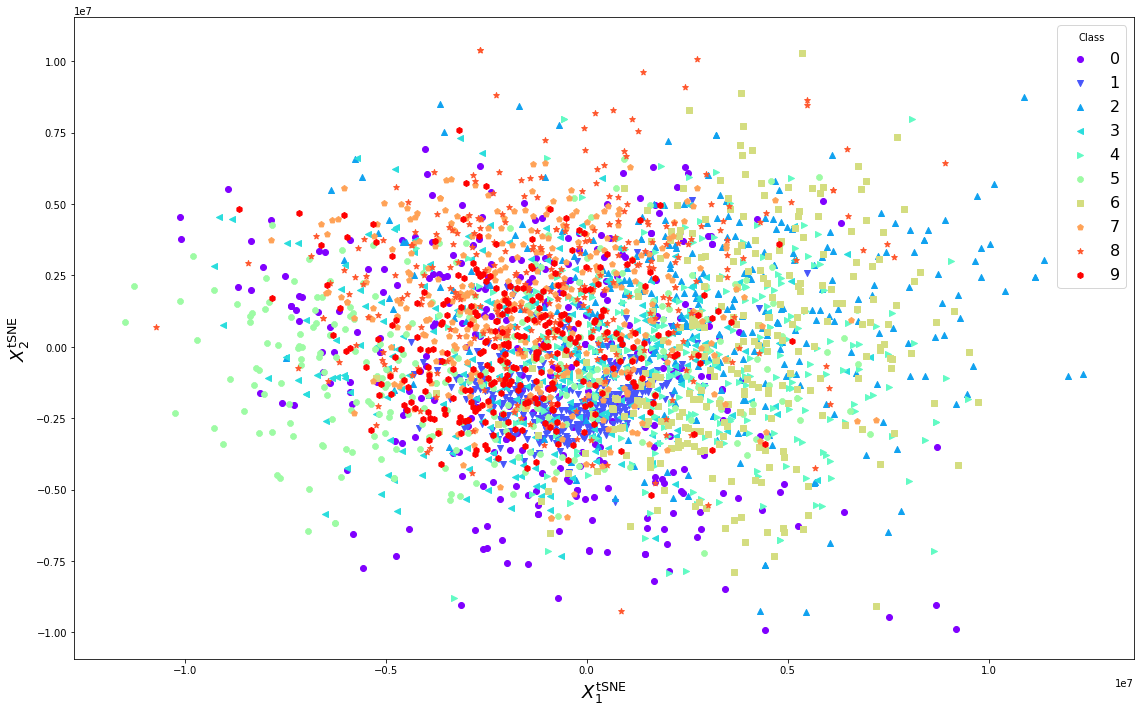

In [32]:
colors = cm.rainbow(np.linspace(0, 1, nr_c))
markers = matplotlib.markers.MarkerStyle.filled_markers

    # Save TSNE figure to file
fig, ax = plt.subplots(figsize=(16,10))
for iclass in range(0, nr_c):
        # Get indices for each class
    idxs = labels==iclass
        # Scatter those points in tsne dims
    ax.scatter(tsne_enc[idxs, 0],
                tsne_enc[idxs, 1],
                marker=markers[iclass],
                c=colors[iclass],
                edgecolor=None,
                label=r'$%i$'%iclass)

    #ax.set_title(r'%s'%fig_title, fontsize=24)
    ax.set_xlabel(r'$X^{\mathrm{tSNE}}_1$', fontsize=18)
    ax.set_ylabel(r'$X^{\mathrm{tSNE}}_2$', fontsize=18)
    plt.legend(title=r'Class', loc='best', numpoints=1, fontsize=16)
    plt.tight_layout()
    fig.savefig('tsne-pca.png')

0 == Fake and 1 == Real
First Episode unsure since untrained on Real Data


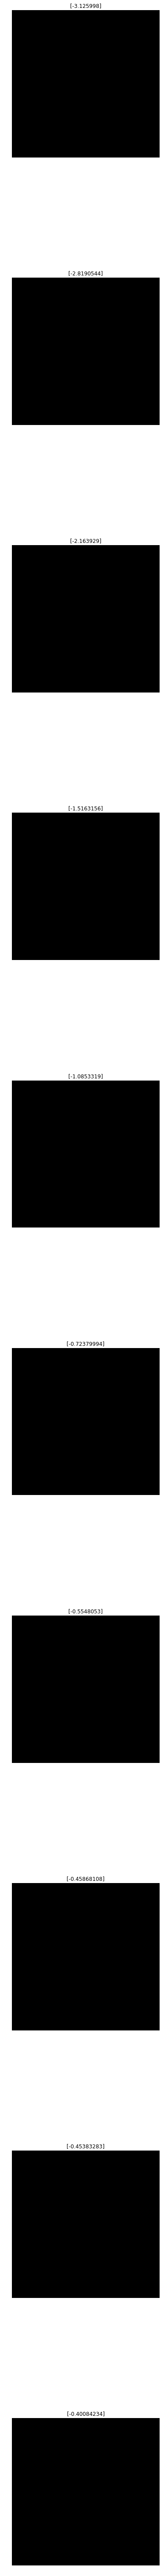

In [36]:
fig, axes = plt.subplots(len(saved_generator_imgs),1, figsize=(6, 110))
fig.subplots_adjust(hspace = .2, wspace=.001)
axes = axes.ravel()

print("0 == Fake and 1 == Real")
print("First Episode unsure since untrained on Real Data")

for idx in range(len(saved_generator_imgs)):
    axes[idx].axis('off')
    axes[idx].imshow(saved_generator_imgs[idx].cpu(), cmap = "gray")
    axes[idx].set_title(generator_predictions[idx].cpu().detach().numpy())